Total conditions: 615
Total co-occurences: 66653
Network density: 0.3530
Is connected: True
20 conditions with most widespread co-occurrence:

 1. Dyspnea                                            | Centrality: 0.9593 | Connections: 589 | Weighted: 853
 2. Pleural effusion                                   | Centrality: 0.9593 | Connections: 589 | Weighted: 853
 3. Electrocardiogram abnormal                         | Centrality: 0.9430 | Connections: 579 | Weighted: 797
 4. Abdominal pain                                     | Centrality: 0.8925 | Connections: 548 | Weighted: 771
 5. Cardiac arrhythmia                                 | Centrality: 0.8925 | Connections: 548 | Weighted: 771
 6. Anemia                                             | Centrality: 0.8909 | Connections: 547 | Weighted: 807
 7. Constipation                                       | Centrality: 0.8730 | Connections: 536 | Weighted: 747
 8. Nausea                                             | Centrality: 0.8664 | Co


Generating additional plots for paper...
Saved: centrality_scatter.png


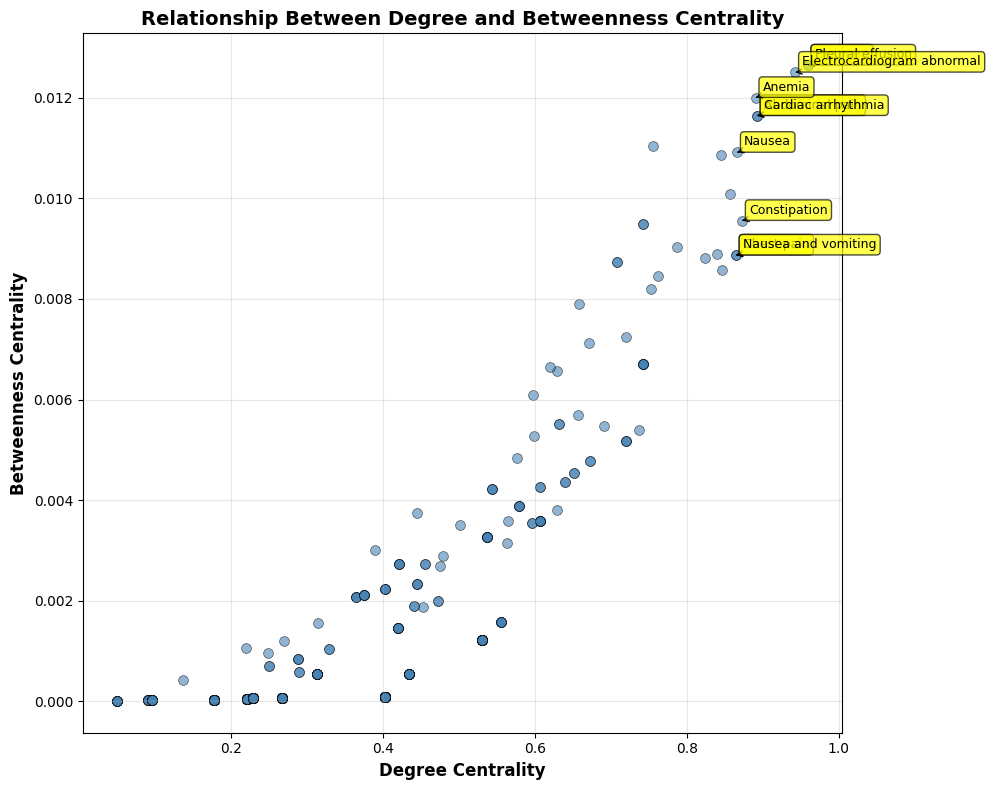

Saved: degree_distribution.png


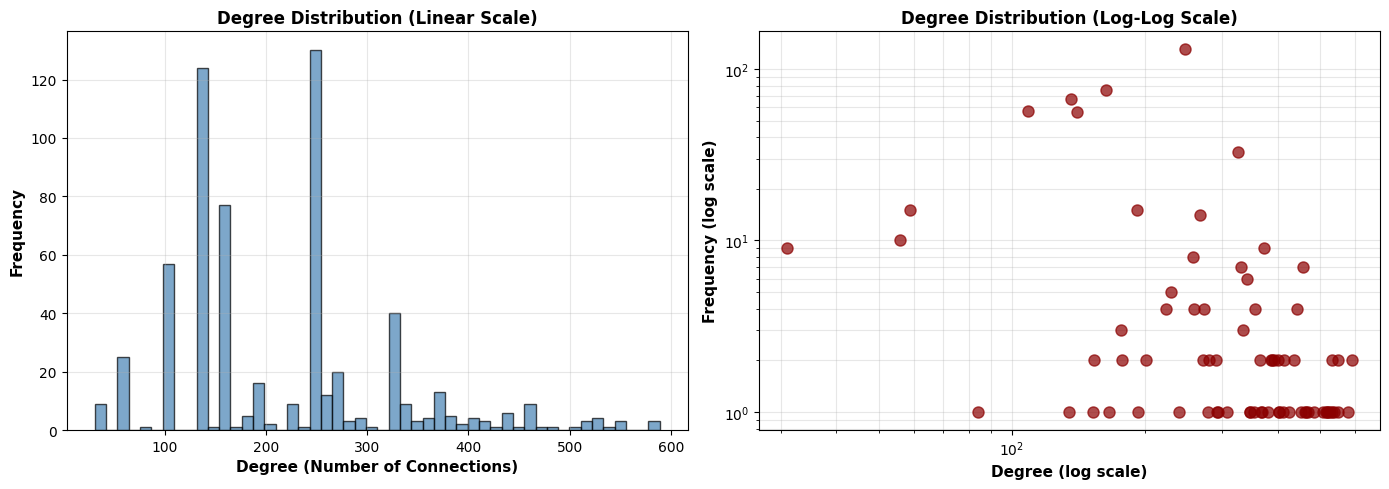

Saved: community_sizes.png


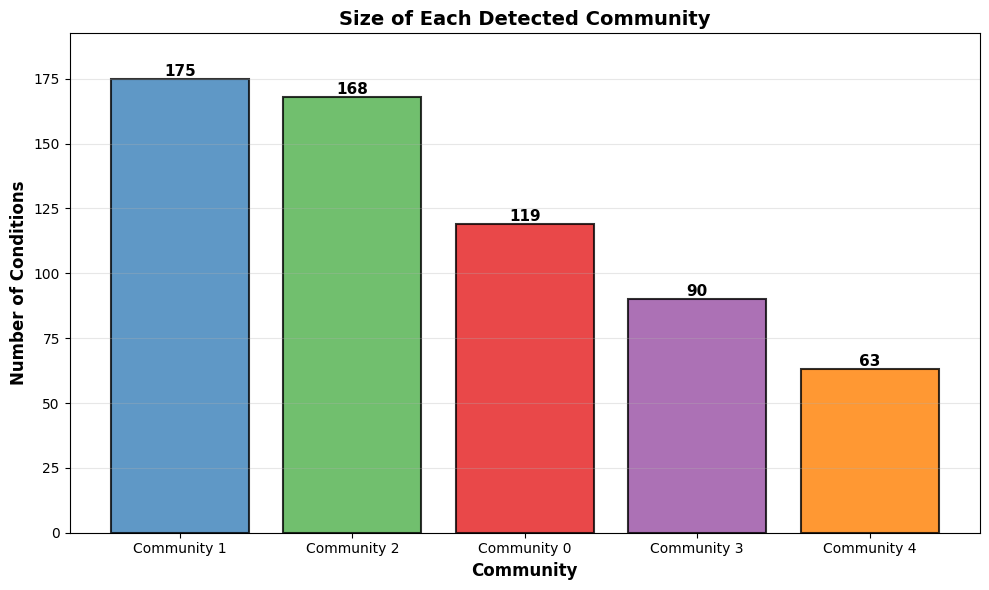

In [1]:
# %%
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
from networkx.algorithms.community import louvain_communities
import numpy as np
import matplotlib.pyplot as plt

# %%
# load edge list
df = pd.read_csv('../input/under-30/edges.csv')

# build weighted graph
G = nx.Graph()
edges = [(row['concept_A'], row['concept_B'], row['n_people']) for _, row in df.iterrows()]
G.add_weighted_edges_from(edges)

# %%
# basic graph statistics
print(f"Total conditions: {G.number_of_nodes()}")
print(f"Total co-occurences: {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.4f}")
print(f"Is connected: {nx.is_connected(G)}")

# %% [markdown]
# <h1>1. Centrality analysis  </h1>
# Analyze nodes by weighted degree centrality and betweenness centrality. Nodes with high degree co-occur with many other conditions, especially when they co-occur in a larger number of patients. Nodes with high betweenness serve as bridges between different co-occurrences, indicating that their development may be associated with a new set of potential co-occurrences. 

# %%
# compute node centralities
degree_centrality = nx.degree_centrality(G)  # normalized 0-1 values
weighted_degree = dict(G.degree(weight='weight'))  # sum of weights
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

# %%
# show top 20 diseases by degree centrality
print("20 conditions with most widespread co-occurrence:\n")
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
for i, (node, cent) in enumerate(sorted_degree[:20], 1):
    degree = G.degree(node)
    w_degree = weighted_degree[node]
    print(f"{i:2d}. {node:50s} | Centrality: {cent:.4f} | Connections: {degree} | Weighted: {w_degree:.0f}")

# %%
print("20 conditions that most strongly bridge different comorbidity groups)\n")
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
for i, (node, cent) in enumerate(sorted_betweenness[:20], 1):
    print(f"{i:2d}. {node:50s} | Centrality: {cent:.4f}")

# %% [markdown]
# <h1>2. First-level community analysis</h1>

# %%
# apply Louvain community detection algorithm
# search a range of resolution values to find best modularity
best_R = 0.0
best_mod = -1.0
for R in np.arange(0.0, 3.1, 0.1):
    comms = louvain_communities(G, weight='weight', seed = 42, resolution=R)
    mod = nx.algorithms.community.modularity(G, comms, weight='weight')
    if mod > best_mod:
        best_mod = mod
        best_R = R

# apply most optimal resolution to get main communities
main_communities = louvain_communities(G, weight='weight', seed=42, resolution=best_R)

# create map of condition node to main community
main_community_map = {}
for idx, community in enumerate(main_communities):
    for node in community:
        main_community_map[node] = idx

# %%
# calculate modularity of partition
modularity = nx.algorithms.community.modularity(G, main_communities, weight='weight')
print(f"Number of main communities detected: {len(main_communities)}")
print(f"Modularity score: {modularity:.4f}\n")

main_community_sizes = sorted([(i, len(comm)) for i, comm in enumerate(main_communities)], 
                               key=lambda x: x[1], reverse=True)
print("Main community sizes:")
for comm_id, size in main_community_sizes:
    print(f"  Community {comm_id}: {size} conditions")

# %% [markdown]
# <h1>3. Sub-communities within main communities</h1>

# %%
# functionalize subcommunity processing to be used in the cell below
def process_subcommunity(nodes, subcom_id):
    subcom_nodes = list(nodes)
    # assign nodes to the subcommunity map
    for node in subcom_nodes:
        subcommunity_map[node] = subcom_id

    # compute average centralities
    subcom_degree_avg = np.mean([degree_centrality[n] for n in subcom_nodes])
    subcom_between_avg = np.mean([betweenness_centrality[n] for n in subcom_nodes])

    # nodes will be sorted by degree centrality
    sorted_nodes = sorted(subcom_nodes, key=lambda x: degree_centrality[x], reverse=True)

    # print summary
    print(f"  Sub-community {subcom_id} ({len(subcom_nodes)} nodes):")
    print(f"    Avg degree centrality: {subcom_degree_avg:.4f}")
    print(f"    Avg betweenness centrality: {subcom_between_avg:.4f}")
    # show up to 10 top nodes
    print("    Top representative nodes:")
    top_nodes = []
    i = 0
    while i < min(10, len(sorted_nodes)):
        print(f"      - {sorted_nodes[i]}")
        top_nodes.append(sorted_nodes[i])
        i += 1

    # append structured info
    subcommunity_info.append({
        'main_comm': main_comm_id,
        'sub_comm': subcom_id,
        'size': len(subcom_nodes),
        'top_nodes': top_nodes,
        'avg_degree': subcom_degree_avg,
        'avg_betweenness': subcom_between_avg
    })

    print()

# %%
# prepare to store sub-community information
subcommunity_map = {}
subcommunity_counter = 0
subcommunity_info = []

# iterate over main communities
for main_comm_id, size in main_community_sizes:
    if size < 20:  # don't subdivide very small communities
        print(f"Main Community {main_comm_id} ({size} nodes): Too small to subdivide\n")
        # process the whole community as one sub-community x.0
        nodes = main_communities[main_comm_id]
        process_subcommunity(nodes, f"{main_comm_id}.0")
        continue
    
    print(f"Main Community {main_comm_id} ({size} nodes):")
    print("-" * 70)
    
    # extract subgraph for this community
    subgraph = G.subgraph(main_communities[main_comm_id]).copy()
    
    # search a range of resolution values to find best modularity
    best_R = 1.0
    best_mod = -1.0
    for R in np.arange(1, 3.1, 0.1):
        comms = louvain_communities(subgraph, weight='weight', seed=42, resolution=R)
        mod = nx.algorithms.community.modularity(subgraph, comms, weight='weight')
        if mod > best_mod:
            best_mod = mod
            best_R = R

    # detect sub-communities with higher resolution for finer granularity
    sub_communities = louvain_communities(subgraph, weight='weight', seed=42, resolution=best_R)
    sub_modularity = nx.algorithms.community.modularity(subgraph, sub_communities, weight='weight')
    
    print(f"  Found {len(sub_communities)} sub-communities (modularity: {sub_modularity:.3f})\n")
    
    # sort sub-communities by size
    sorted_subcoms = sorted(enumerate(sub_communities), key=lambda x: len(x[1]), reverse=True)
    
    # iterate over sub-communities
    for sub_idx, (original_idx, subcom) in enumerate(sorted_subcoms):
        subcom_id = f"{main_comm_id}.{sub_idx}"
        process_subcommunity(subcom, subcom_id)

# %% [markdown]
# <h1>4. Graph plot</h1>

# %%
# Add node attributes
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')
nx.set_node_attributes(G, betweenness_centrality, 'betweenness_centrality')
nx.set_node_attributes(G, main_community_map, 'main_community')
nx.set_node_attributes(G, subcommunity_map, 'subcommunity')

# Layout
pos = nx.spring_layout(G, seed=42, k=1.0, iterations=50, weight=None)

# Prepare edge traces
edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.3, color='rgba(150,150,150,0.3)'),
    hoverinfo='none',
    mode='lines'
)

# Node coordinates and attributes
node_x, node_y = [], []
node_text = []
node_color = []
node_size = []

# Extended color palette for main communities
palette = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', 
           '#ffff33', '#a65628', '#f781bf', '#1b9e77', '#d95f02',
           '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d']

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    
    deg_cent = degree_centrality[node]
    betw_cent = betweenness_centrality[node]
    main_comm = main_community_map[node]
    sub_comm = subcommunity_map[node]
    
    comm_color = palette[main_comm % len(palette)]
    node_color.append(comm_color)
    
    # Size nodes by degree centrality
    node_size.append(3 + deg_cent * 30)
    neighbors = list(G.neighbors(node))
    neighbor_comms = set(main_community_map[n] for n in neighbors)
    
    hover_text = (
        f"<b>{node}</b><br>"
        f"Degree Centrality: {deg_cent:.4f}<br>"
        f"Betweenness: {betw_cent:.4f}<br>"
        f"Main Community: {main_comm}<br>"
        f"Sub-community: {sub_comm}<br>"
        f"Connections: {len(neighbors)}<br>"
        f"Bridges {len(neighbor_comms)} main communities"
    )
    node_text.append(hover_text)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        color=node_color,
        size=node_size,
        line=dict(width=0.5, color='white'),
        opacity=0.8
    ),
    hovertext=node_text,
)

# Build figure
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title=dict(
            text=f'Under-30 Mortality Disease Co-occurrence Network<br><sub>{len(main_communities)} main communities (modularity: {modularity:.3f})</sub>',
            font=dict(size=18),
            x=0.5,
            xanchor='center'
        ),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=20, r=20, t=80),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        plot_bgcolor='white',
        width=1400,
        height=900
    )
)
fig.show()

fig.write_html('network_visualization.html')

# %% [markdown]
# <h1>5. Additional Plots for Paper</h1>

# %%
# ============================================================================
# PLOT 1: CENTRALITY COMPARISON SCATTER PLOT
# ============================================================================
print("\nGenerating additional plots for paper...")

plt.figure(figsize=(10, 8))

# Get centrality values
deg_values = list(degree_centrality.values())
betw_values = list(betweenness_centrality.values())
nodes = list(degree_centrality.keys())

# Create scatter plot
plt.scatter(deg_values, betw_values, alpha=0.6, s=50, c='steelblue', edgecolors='black', linewidth=0.5)

# Label top 10 nodes
top_10_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for node, deg_cent in top_10_nodes:
    betw_cent = betweenness_centrality[node]
    plt.annotate(node, 
                xy=(deg_cent, betw_cent), 
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.xlabel('Degree Centrality', fontsize=12, fontweight='bold')
plt.ylabel('Betweenness Centrality', fontsize=12, fontweight='bold')
plt.title('Relationship Between Degree and Betweenness Centrality', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('centrality_scatter.png', dpi=300, bbox_inches='tight')
print("Saved: centrality_scatter.png")
plt.show()
plt.close()

# %%
# ============================================================================
# PLOT 2: DEGREE DISTRIBUTION PLOT
# ============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale histogram
degrees = [G.degree(n) for n in G.nodes()]
ax1.hist(degrees, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Degree (Number of Connections)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Degree Distribution (Linear Scale)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Log-log scale (to check for power-law)
degree_counts = {}
for d in degrees:
    degree_counts[d] = degree_counts.get(d, 0) + 1

x = sorted(degree_counts.keys())
y = [degree_counts[k] for k in x]

ax2.loglog(x, y, 'o', markersize=8, color='darkred', alpha=0.7)
ax2.set_xlabel('Degree (log scale)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency (log scale)', fontsize=11, fontweight='bold')
ax2.set_title('Degree Distribution (Log-Log Scale)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('degree_distribution.png', dpi=300, bbox_inches='tight')
print("Saved: degree_distribution.png")
plt.show()
plt.close()

# %%
# ============================================================================
# PLOT 3: COMMUNITY SIZE BAR CHART
# ============================================================================
plt.figure(figsize=(10, 6))

# Get community sizes
comm_sizes = sorted([(i, len(comm)) for i, comm in enumerate(main_communities)], 
                    key=lambda x: x[1], reverse=True)
comm_ids = [f"Community {c[0]}" for c in comm_sizes]
sizes = [c[1] for c in comm_sizes]

# Color palette matching the network visualization
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
bar_colors = [colors[c[0] % len(colors)] for c in comm_sizes]

bars = plt.bar(comm_ids, sizes, color=bar_colors, edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Community', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conditions', fontsize=12, fontweight='bold')
plt.title('Size of Each Detected Community', fontsize=14, fontweight='bold')
plt.ylim(0, max(sizes) * 1.1)  # Add 10% space at top
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('community_sizes.png', dpi=300, bbox_inches='tight')
print("Saved: community_sizes.png")
plt.show()
plt.close()